In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist


from utils import geometry

In [1]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [25]:
pixel_size=1024
micron_size=551.49

exp_id='20230203_1_IN_BFPCAAX-CheHis_us'
data_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data/'
plot_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Plots/'
files_u=sorted(glob(data_dir+'20230203_1_us_0p5_fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
files_s=sorted(glob(data_dir+'20230203_1_us_*_fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))[1:]
df=pd.read_csv(files_u[0])
df['frame']=1
df['time']=0
df['area_norm']=df.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
df['perimeter_norm']=df.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
df['shear_strain']=(df.cell_perimeter_microns/df.cell_area_microns) * df.cell_zeta
df['area_change_norm']=(df.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
df['area_change']=(df.cell_area_microns-df[df.time==0].cell_area_microns)
df['angle_horizontal']=abs(np.where(df[df.time==0].major_shape_axis_alignment_rads<np.pi/2,df[df.time==0].major_shape_axis_alignment_rads, df[df.time==0].major_shape_axis_alignment_rads-np.pi))
i=1
for f in files_s:
    data_s=pd.read_csv(f)
    data_s['frame']=int(f.split('\\')[-1].split('_')[4][2:])
    data_s['time']=(i+4)*60
    data_s['area_norm']=data_s.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
    data_s['perimeter_norm']=data_s.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
    data_s['shear_strain']=(data_s.cell_perimeter_microns/data_s.cell_area_microns) * data_s.cell_zeta
    data_s['area_change']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns)
    data_s['area_change_norm']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
    data_s['angle_horizontal']=abs(np.where(data_s.major_shape_axis_alignment_rads<np.pi/2,data_s.major_shape_axis_alignment_rads, data_s.major_shape_axis_alignment_rads-np.pi))
    df=pd.concat([df, data_s], ignore_index=True)
    i+=5


df.to_csv(data_dir+'20230203_1_collated.csv')

In [26]:
files_s

['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_1p0_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_1p5_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_2p0_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_2p5_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_3p0_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Data\\20230203_1_us_3p5_fr1_cell_data_all_Gamma_0.172_Lambda_-0.259.csv',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Dat

In [4]:
df.columns

Index(['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'cell_perimeter_nd', 'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter',
       'circularity', 'cell_edge_count', 'cell_shear', 'cell_zeta',
       'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads',
       'frame', 'time', 'area_norm', 'perimeter_norm', 'shear_strain',
       'area_change_norm', 'area_change', 'angle_horizontal'],
      dtype='object')

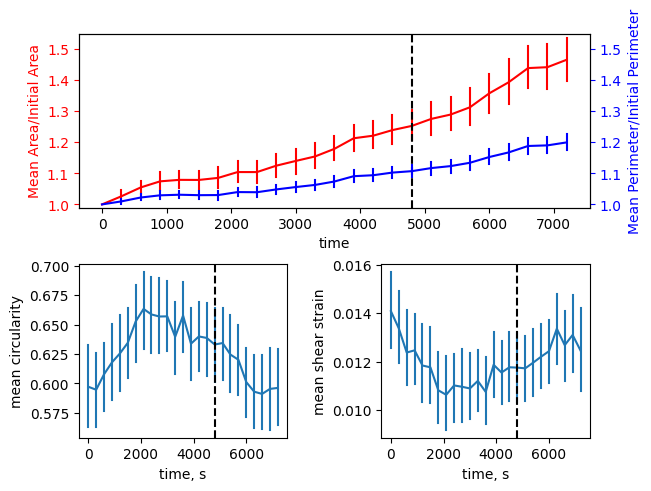

In [31]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax11 = ax1.twinx()
sns.lineplot(data=df, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax1, c='red')
sns.lineplot(data=df, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax11, c='blue')
ax1.tick_params(axis='y', colors='red')
ax11.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.99,1.55)
ax11.set_ylim(0.99,1.55)
ax11.set(ylabel="Mean Perimeter/Initial Perimeter")
ax1.set(ylabel="Mean Area/Initial Area")
ax1.yaxis.label.set_color('red')
ax11.yaxis.label.set_color('blue')
ax1.axvline(4800, linestyle='--', color='black')

sns.lineplot(data=df, x="time", y="circularity", err_style='bars', errorbar='ci',ax=ax2)
sns.lineplot(data=df, x="time", y="shear_strain", err_style='bars', errorbar='ci', ax=ax3)
ax2.set_xlabel("time, s")
ax2.set_ylabel("mean circularity")
ax3.set_xlabel("time, s")
ax3.set_ylabel("mean shear strain")
ax2.axvline(4800, linestyle='--', color='black')
ax3.axvline(4800, linestyle='--', color='black')


fig.suptitle(" ")


plt.savefig(plot_dir+'/shape_line_all.png', dpi=300, bbox_inches='tight')

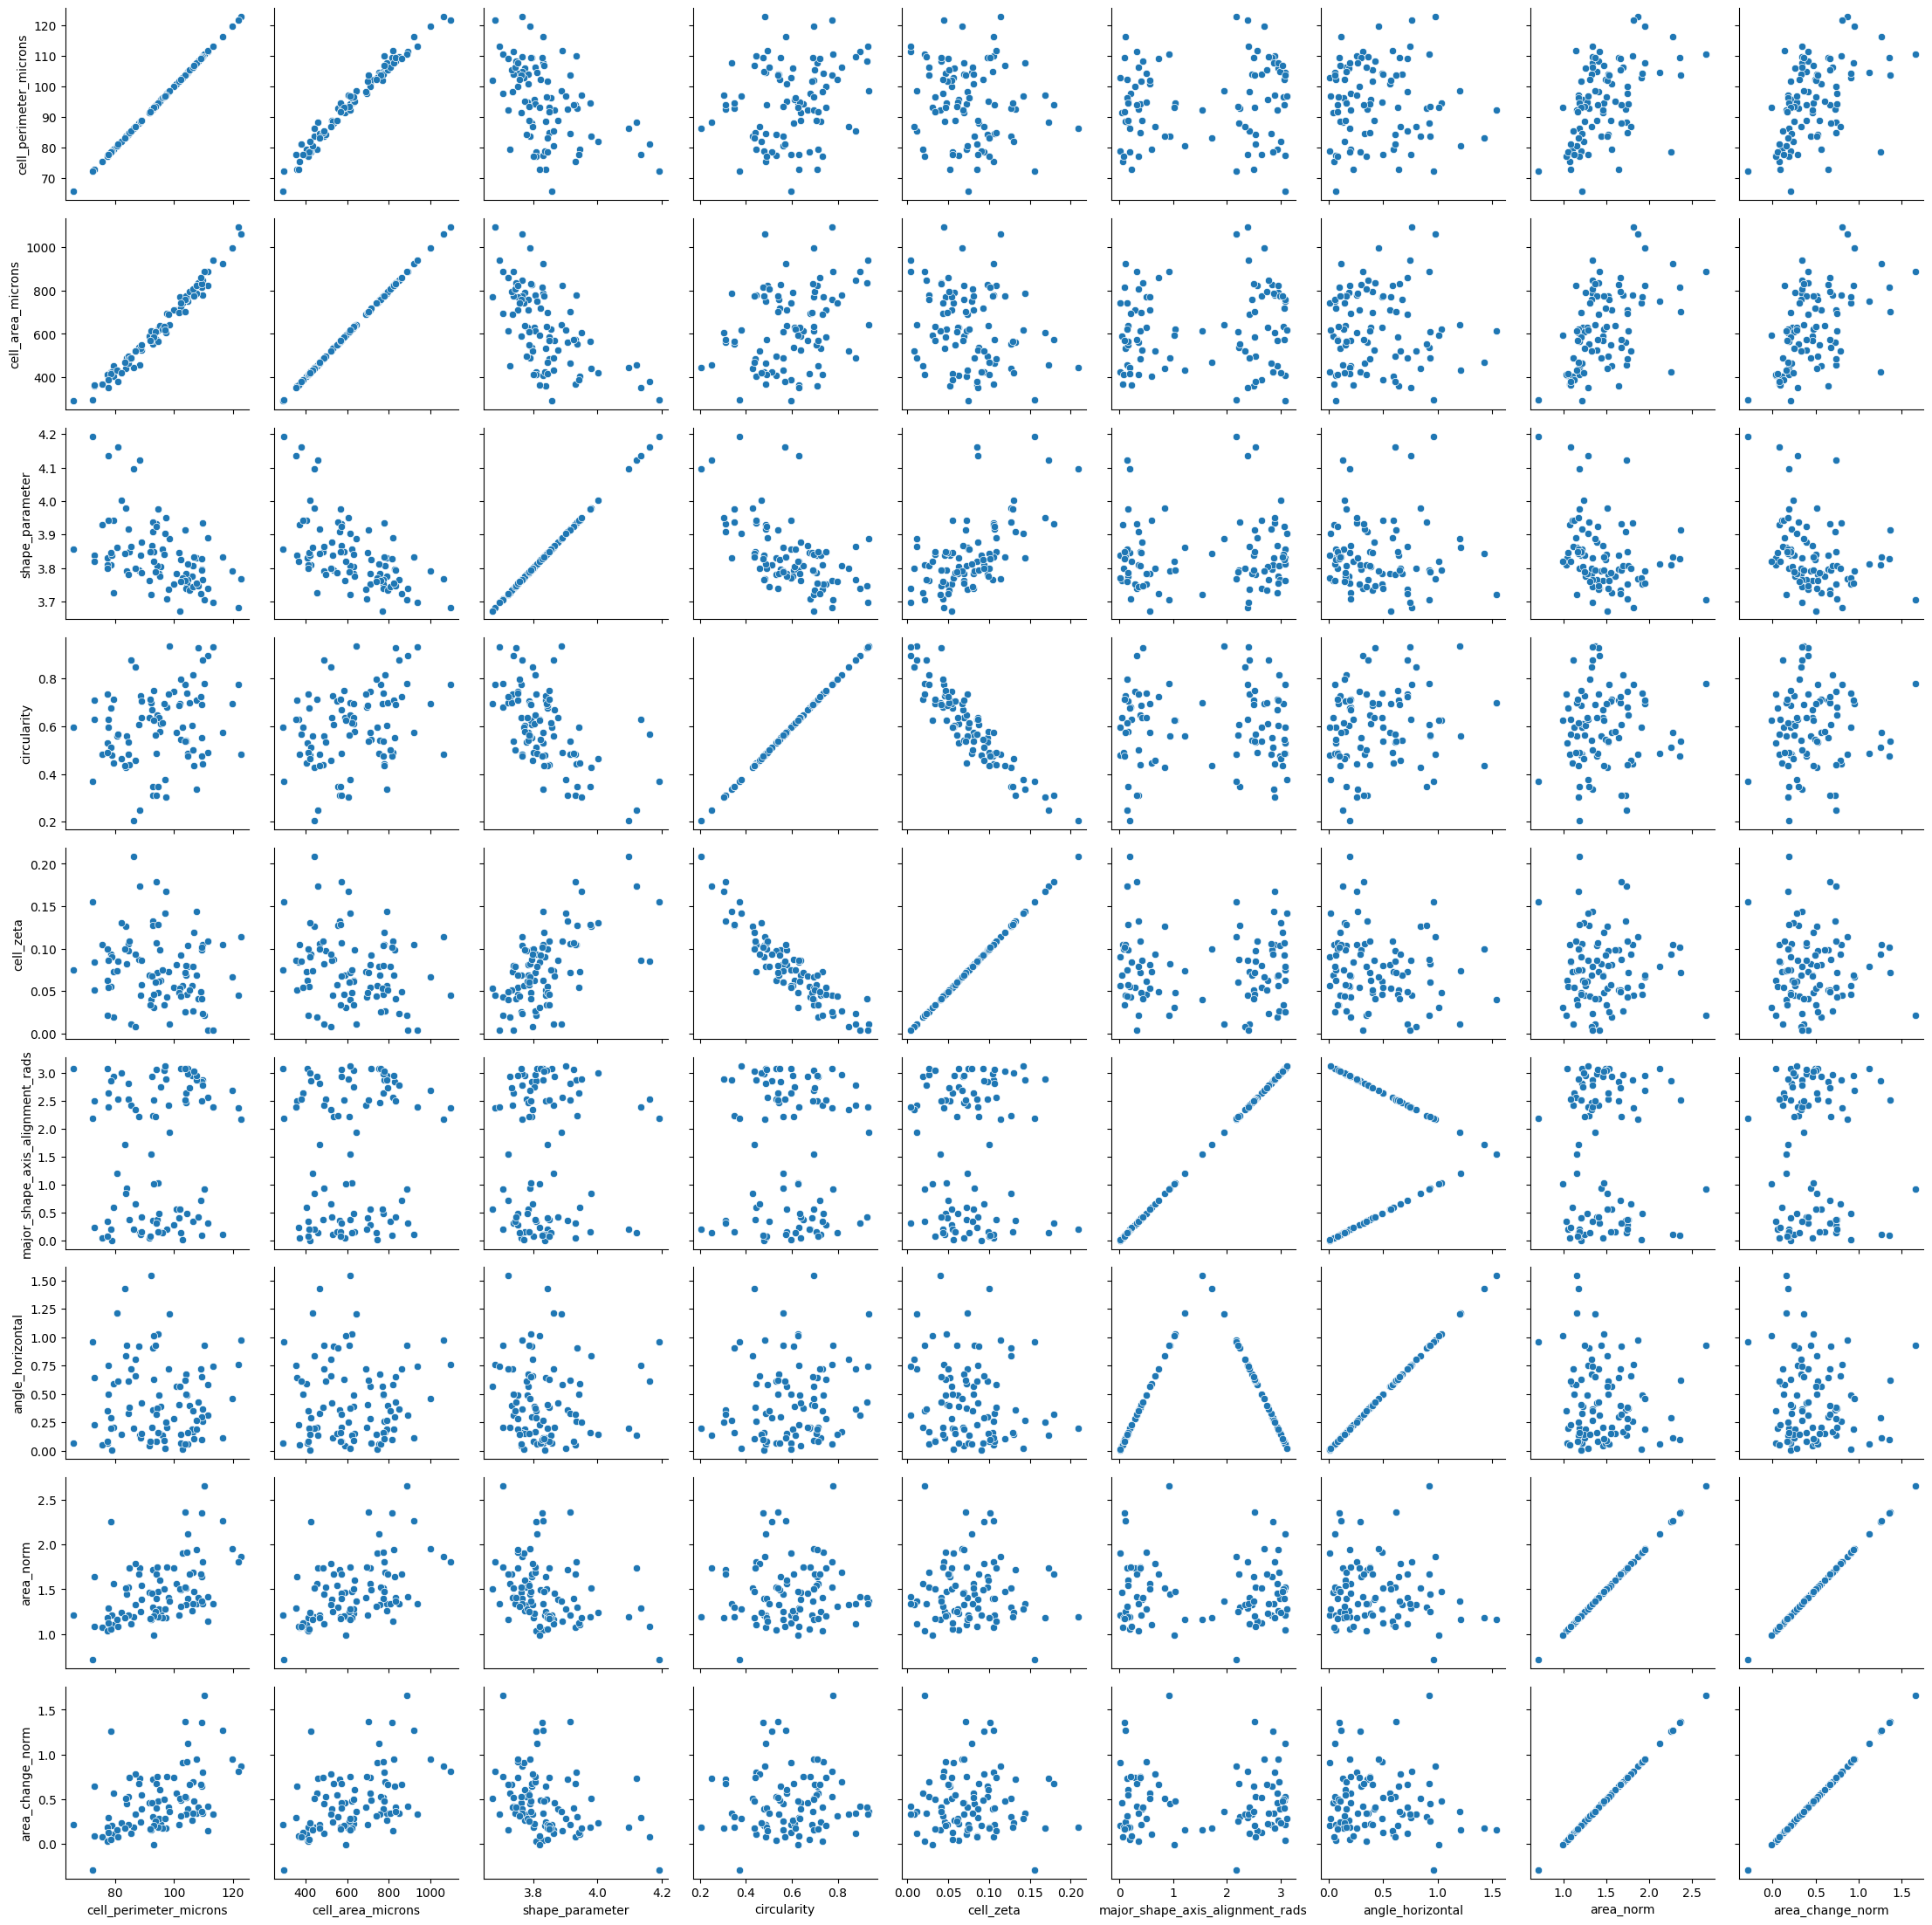

In [160]:
df_pp=df[df.time==7200][[ 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter',
       'circularity',  'cell_zeta',
       'major_shape_axis_alignment_rads', 'angle_horizontal', 'area_norm', 'area_change_norm']]
g = sns.PairGrid(df_pp)
g.map(sns.scatterplot)

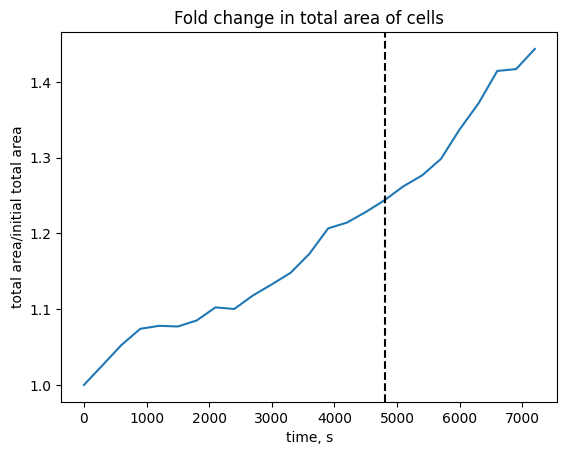

In [48]:
t=np.linspace(0, 7200, 25)
plt.plot(t,df.groupby('time').sum().cell_area_microns/df.groupby('time').sum().cell_area_microns[0])
plt.axvline(4800, linestyle='--', color='black')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

In [46]:
df.groupby('time').sum().cell_area_microns[0]

40455.68182611251

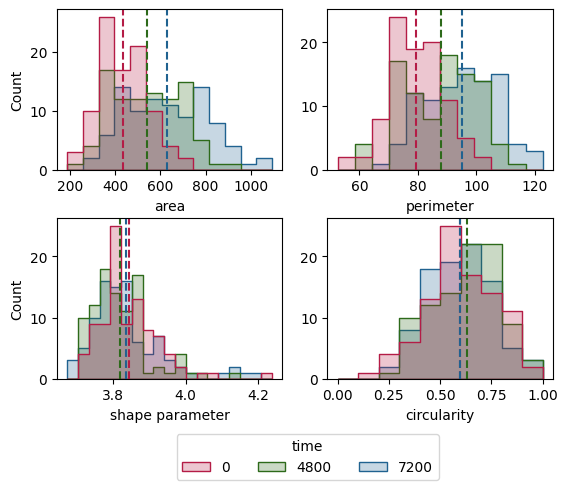

In [49]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0])
ax[0,0].axvline(np.mean(df[df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(df[df.time ==4800].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(df[df.time ==7200].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='cell_perimeter_microns', element="step",legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[0,1])
ax[0,1].axvline(np.mean(df[df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(df[df.time ==4800].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(df[df.time ==7200].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='circularity', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,1], binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(df[df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==4800].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==7200].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='shape_parameter', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,0])
ax[1,0].axvline(np.mean(df[df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==4800].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==7200].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -1.6), frameon=True, ncol=3)
plt.savefig(plot_dir+'/shape_hists_all.png', dpi=300, bbox_inches='tight')

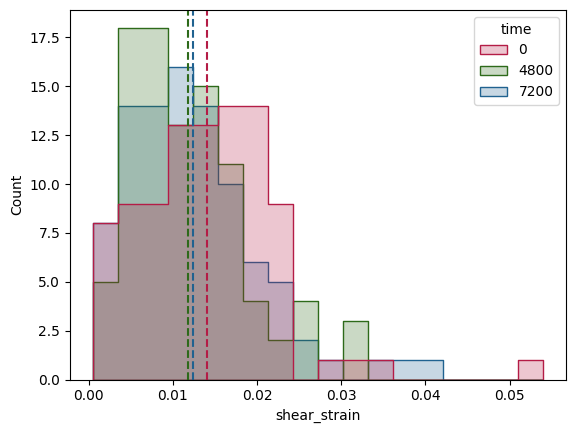

In [50]:
sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='shear_strain', element="step", palette=sns.husl_palette(3,l=.4))
plt.axvline(np.mean(df[df.time ==0].shear_strain), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
plt.axvline(np.mean(df[df.time ==4800].shear_strain), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
plt.axvline(np.mean(df[df.time ==7200].shear_strain), c=sns.husl_palette(3,l=.4)[2], linestyle='--')
plt.xlabel('shear_strain')
plt.savefig(plot_dir+'/shear_strain.png', dpi=300)

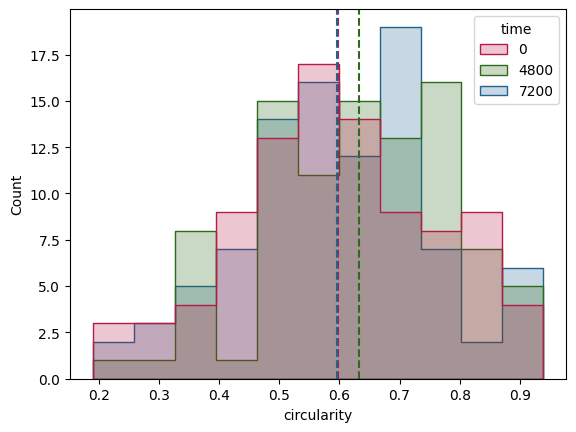

In [86]:
sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='circularity', element="step", palette=sns.husl_palette(3,l=.4))
plt.axvline(np.mean(df[df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
plt.axvline(np.mean(df[df.time ==4800].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
plt.axvline(np.mean(df[df.time ==7200].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')
plt.xlabel('circularity')
plt.savefig(plot_dir+'/circ_hist.png', dpi=300)

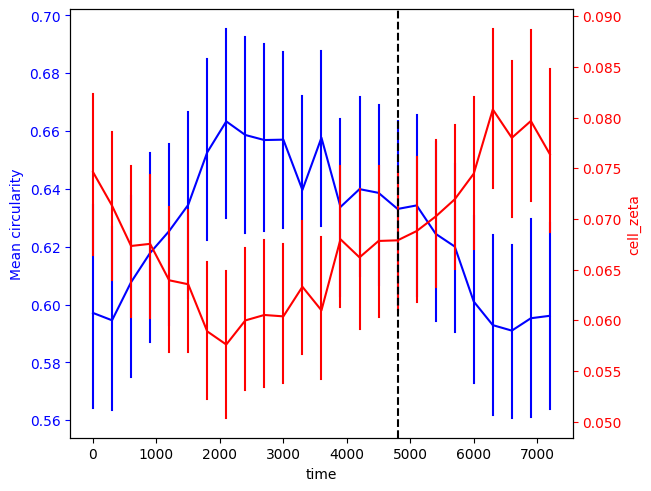

In [119]:
# sns.lineplot(data=df, x='time', y='angle_horizontal', errorbar='ci', err_style='bars')
# sns.lineplot(data=df, x='time', y='circularity', errorbar='ci', err_style='bars')
# plt.ylabel("Mean Angle with horizontal")
# plt.xlabel("time, s")
# plt.title("Angle of long axis with horizontal")
# plt.ylim(0, 90/180*np.pi)
# plt.yticks(np.linspace(0, 90/180*np.pi, 3),[0,'$\\frac{\pi}{4}$','$\\frac{\pi}{2}$'])

fig,ax = plt.subplots(layout="constrained")
ax11 = ax.twinx()
#sns.lineplot(data=df, x='time', y='angle_horizontal', errorbar='ci', err_style='bars', ax=ax11, color='red')
sns.lineplot(data=df, x='time', y='cell_zeta', errorbar='ci', err_style='bars', ax=ax11, color='red')
sns.lineplot(data=df, x='time', y='circularity', errorbar='ci', err_style='bars', ax=ax, color='blue')
ax11.tick_params(axis='y', colors='red')
ax.tick_params(axis='y', colors='blue')
#ax11.set_ylim(0, np.pi*3/8)
#ax.set_ylim(0.99,1.55)
#ax11.set_ylim(0.99,1.55)
ax.set(ylabel="Mean circularity")
#ax11.set(ylabel="Mean Angle with horizontal")
ax11.yaxis.label.set_color('red')
ax.yaxis.label.set_color('blue')
plt.axvline(4800, linestyle='--', color='black')

In [107]:
np.pi/4

0.7853981633974483

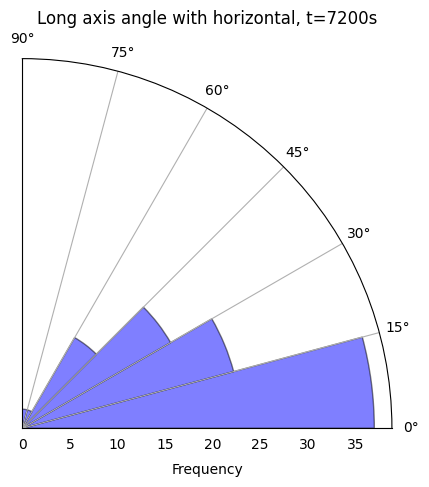

In [57]:
    bins = np.linspace(0.0, 90/180 *np.pi,7)

    #angle=rotate_angle_0

    n, _, _ = plt.hist(df[df.time==7200].angle_horizontal,range=[0,np.pi/2], bins=6)

    plt.clf()
    width = np.pi/2 /6
    ax = plt.subplot(1, 1, 1, projection='polar')
    bars = ax.bar(bins[:6], n, width=width, bottom=0, align='edge',color='blue', edgecolor='k')
    for bar in bars:
        bar.set_alpha(0.5)
        
    ax.set_xticks(bins)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.yaxis.grid(False)
    ax.set_xlabel('Frequency')
    ax.set_title('Long axis angle with horizontal, t=7200s')
    ax.xaxis.labelpad=20
    plt.savefig(plot_dir+'/angle_7200.png', dpi=300, bbox_inches='tight')

<AxesSubplot: xlabel='angle_horizontal', ylabel='area_norm'>

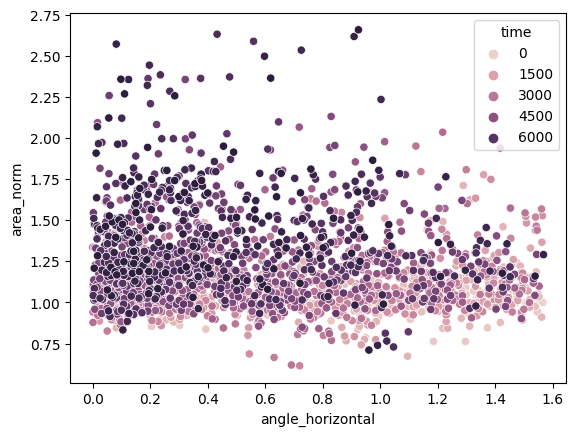

In [100]:
sns.scatterplot(data=df, y='area_norm', x='angle_horizontal', hue='time')

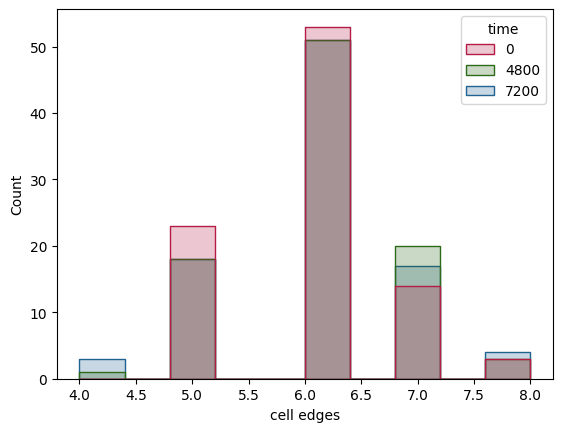

In [85]:
sns.histplot(data=df[(df.time ==0) | (df.time==4800)| (df.time==7200)], hue='time',x='cell_edge_count', element="step", palette=sns.husl_palette(3,l=.4))

plt.xlabel('cell edges')
plt.savefig(plot_dir+'/cec_hist.png', dpi=300)

<AxesSubplot: xlabel='cell_area_microns', ylabel='shear_strain'>

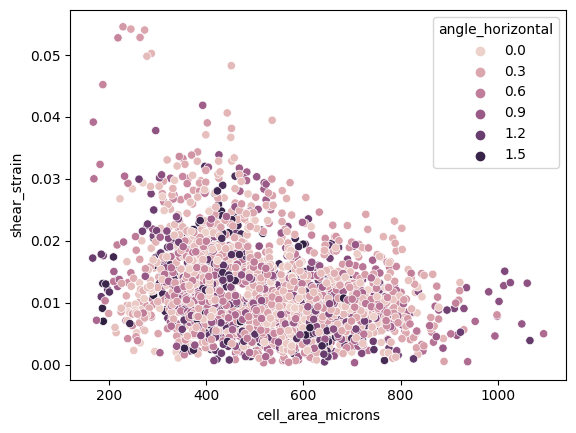

In [96]:
sns.scatterplot(data=df, y='shear_strain', x='cell_area_microns', hue='angle_horizontal')

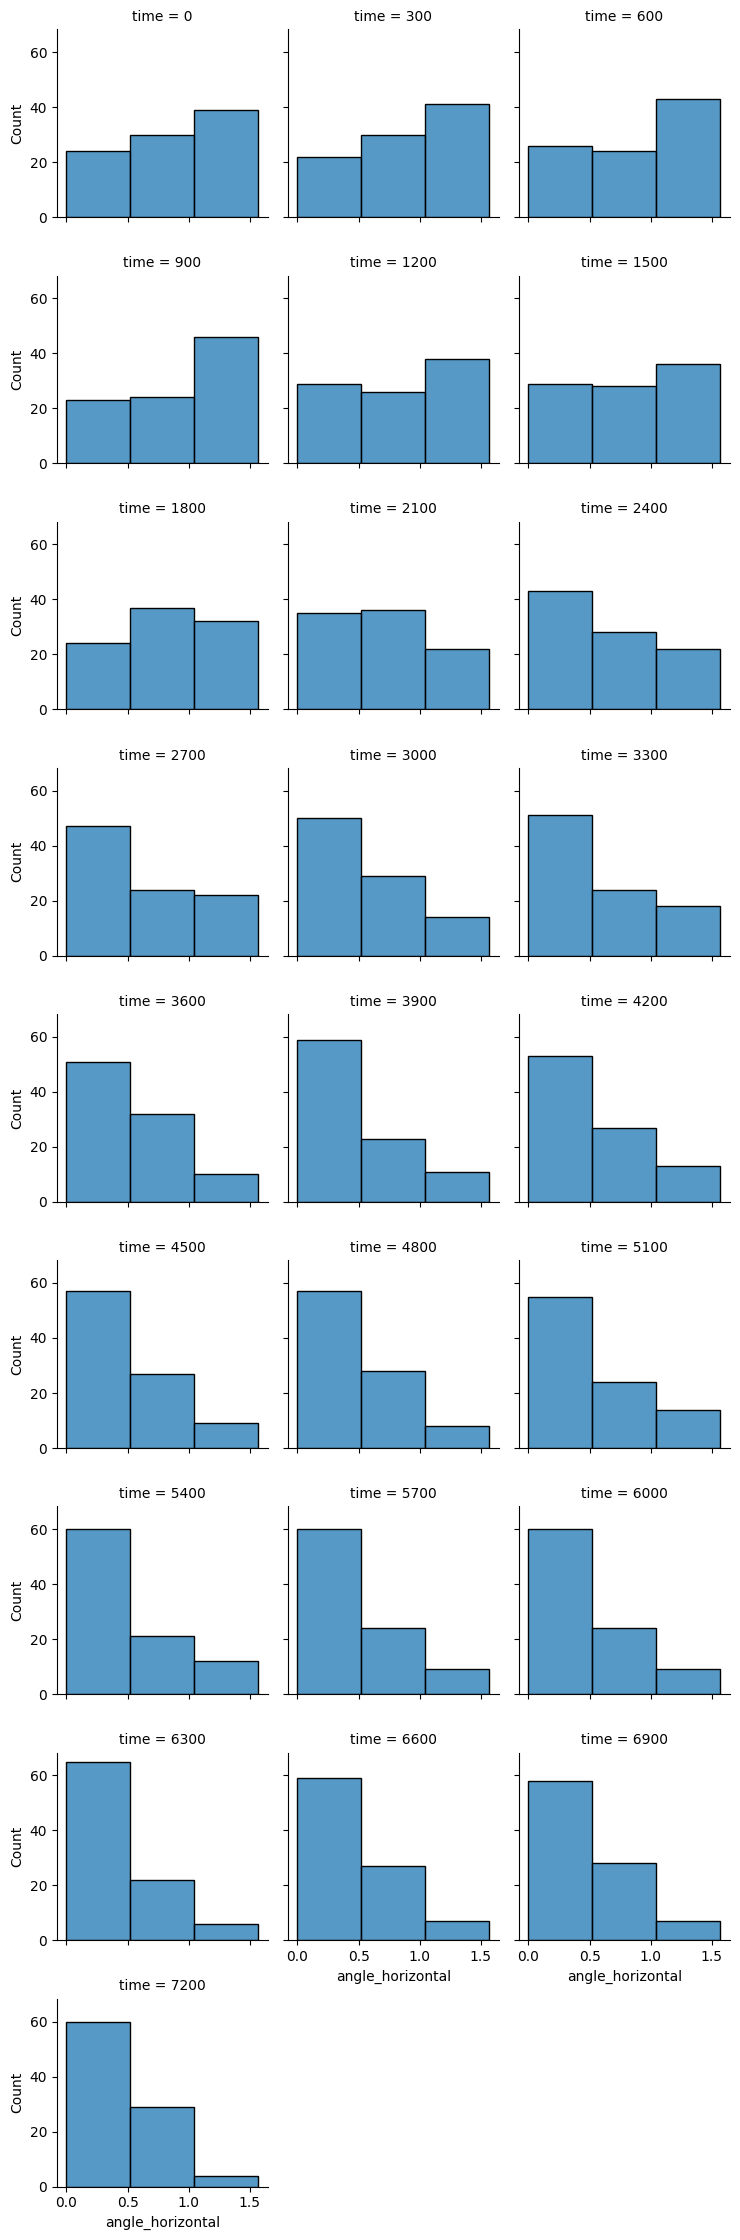

In [124]:
g = sns.FacetGrid(df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='count', binrange=[0, np.pi/2],bins=3)

In [126]:
indata_dir="C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230203_incremental\\Matrices"
R0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_R.txt')[0]) 
R4800  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_R.txt')[0]) 
R7200  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr41'+'_*Matrix_R.txt')[0]) 

R0=R0*(micron_size/pixel_size)
R4800=R4800*(micron_size/pixel_size)
R7200=R7200*(micron_size/pixel_size)

A0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_A.txt')[0]) 
A4800  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_A.txt')[0]) 
A7200  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr41'+'_*Matrix_A.txt')[0]) 



B0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_B.txt')[0]) 
B4800  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_B.txt')[0]) 
B7200  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr41'+'_*Matrix_B.txt')[0]) 

C0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_C.txt')[0]) 
C4800  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_C.txt')[0]) 
C7200  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr41'+'_*Matrix_C.txt')[0]) 


cec0=geometry.get_edge_count(B0)
cec4800=geometry.get_edge_count(B4800)
cec7200=geometry.get_edge_count(B7200)
cc0=geometry.get_cell_centres(C0, R0, cec0)
cc4800=geometry.get_cell_centres(C4800, R4800, cec4800)
cc7200=geometry.get_cell_centres(C7200, R7200, cec7200)

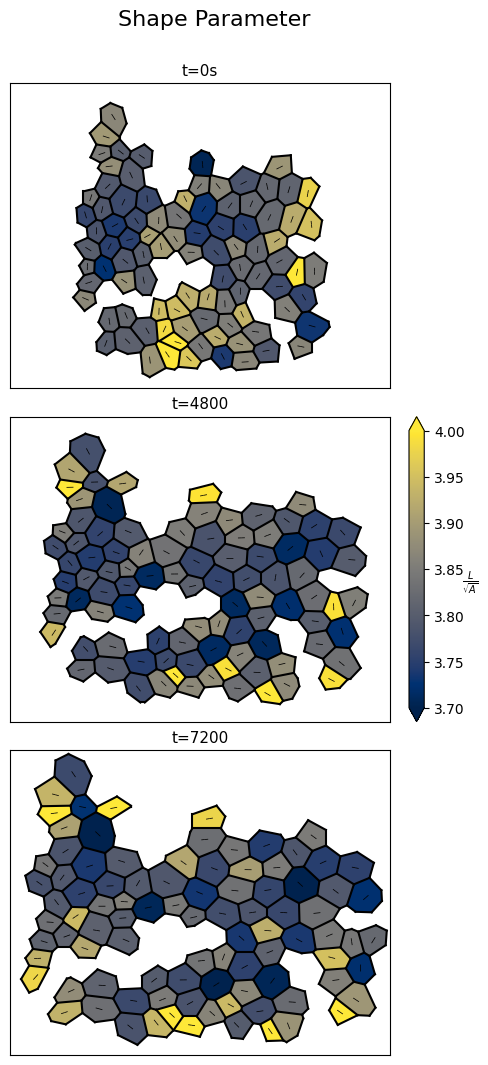

In [156]:
    R0=R0-np.mean(R0, axis=0)
    cc0=geometry.get_cell_centres(C0, R0, cec0)

    R4800=R4800-np.mean(R4800, axis=0)
    cc4800=geometry.get_cell_centres(C4800, R4800, cec4800)

    R7200=R7200-np.mean(R7200, axis=0)
    cc7200=geometry.get_cell_centres(C7200, R7200, cec7200)
    #plot_variable=Area300/Area0 ###Set variable to plot

    fig, ax = plt.subplots(3,subplot_kw={'aspect': 'equal'}, layout='compressed')

    #xlim=(-350, 250)
    #ylim=(-300, 300)

    plt.setp(ax, xlim=xlim, ylim=ylim)

    # N_c=np.shape(C300)[0]

    # patches_out = []

    # for i in range(N_c):
    #     polygon = make_polygon(i, C300, R300, cc300)

        
    #     if np.isnan(plot_variable[i]):
    #         polygonLow = polygon
    #         patches_out.append(polygonLow)






    

    polys=plot_polys(C0, R0, cc0)
    #p_out.set_facecolor('grey')
    polys.set_array(np.array(df[df.time==0].shape_parameter))
    polys.set_cmap('cividis') ###set polygon colourmap here
    polys.set_clim(3.7, 4)
    ax[0].add_collection(polys) 

    polys=plot_polys(C4800, R4800, cc4800)
    polys.set_array(np.array(df[df.time==4800].shape_parameter))
    polys.set_cmap('cividis') ###set polygon colourmap here
    polys.set_clim(3.7, 4)
    ax[1].add_collection(polys) 
    #ax.add_collection(p_out) 

    polys=plot_polys(C7200, R7200, cc7200)
    polys.set_array(np.array(df[df.time==7200].shape_parameter))
    polys.set_cmap('cividis') ###set polygon colourmap here
    polys.set_clim(3.7, 4)
    ax[2].add_collection(polys) 



    ax[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[0].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    
    ax[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[1].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    ax[2].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[2].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    N_e=np.shape(A0)[0]
    beg_edge = ((abs(A0) - A0)*0.5)@R0
    end_edge = ((abs(A0) + A0)*0.5)@R0
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            ax[0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

    N_e=np.shape(A4800)[0]
    beg_edge = ((abs(A4800) - A4800)*0.5)@R4800
    end_edge = ((abs(A4800) + A4800)*0.5)@R4800
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            ax[1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

    N_e=np.shape(A7200)[0]
    beg_edge = ((abs(A7200) - A7200)*0.5)@R7200
    end_edge = ((abs(A7200) + A7200)*0.5)@R7200
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            ax[2].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')
    
    #plot_alignment_axis(cc300,strain_angle_R)
    #plot_alignment_axis(cc3600,np.asarray(df[df.time==3600].major_shape_axis_alignment_rads))
    for i in range(len(cc0)):
        ax[0].quiver(cc0[i,0],cc0[i,1],np.cos(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],np.sin(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
        ax[0].quiver(cc0[i,0],cc0[i,1],-np.cos(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],-np.sin(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
    for i in range(len(cc4800)):
        ax[1].quiver(cc4800[i,0],cc4800[i,1],np.cos(np.asarray(df[df.time==4800].major_shape_axis_alignment_rads))[i],np.sin(np.asarray(df[df.time==4800].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
        ax[1].quiver(cc4800[i,0],cc4800[i,1],-np.cos(np.asarray(df[df.time==4800].major_shape_axis_alignment_rads))[i],-np.sin(np.asarray(df[df.time==4800].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
    for i in range(len(cc7200)):
        ax[2].quiver(cc7200[i,0],cc7200[i,1],np.cos(np.asarray(df[df.time==7200].major_shape_axis_alignment_rads))[i],np.sin(np.asarray(df[df.time==7200].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
        ax[2].quiver(cc7200[i,0],cc7200[i,1],-np.cos(np.asarray(df[df.time==7200].major_shape_axis_alignment_rads))[i],-np.sin(np.asarray(df[df.time==7200].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)

    #ax.set_title('Area/Initial Area, t=300s') ###change title
    ax[0].set_xlim([-180, 200])
    ax[0].set_ylim([-130, 175])
    ax[1].set_xlim([-180, 200])
    ax[1].set_ylim([-130, 175])
    ax[2].set_xlim([-180, 200])
    ax[2].set_ylim([-130, 175])
    #plt.subplots_adjust(wspace=-0.05, hspace=None)
    ax[0].set_title("t=0s", fontsize=11)
    ax[1].set_title("t=4800", fontsize=11)
    ax[2].set_title("t=7200", fontsize=11)
    #cbar = fig.colorbar(polys, extend='both', shrink=0.6)
    #cbar.ax.set_ylabel('Area/Initial Area', rotation=90) ###set colorbar label
    #plt.gca().set_aspect('equal')
    plt.suptitle("Shape Parameter", fontsize=16, x=0.45, y=1.05)
    #plt.figure(figsize=(10,6))
    #cbar=fig.colorbar(polys, ax=ax.ravel().tolist(), extend='both', shrink=0.5)
    #cbar = fig.colorbar(polys,ax=ax[0])
    cbar = fig.colorbar(polys,ax=ax[1], extend='both')
    #cbar = fig.colorbar(polys,ax=ax[2])
    cbar.ax.set_ylabel('$\\frac{L}{\sqrt{A}}$', rotation=0) ###set colorbar label

    fig.set_size_inches(6,10)

    #plt.tight_layout()

    ##uncomment to save
    fig.savefig(plot_dir+'shape_factor_0_4800_7200.png', dpi=300, bbox_inches='tight')

<AxesSubplot: xlabel='time', ylabel='shape_parameter'>

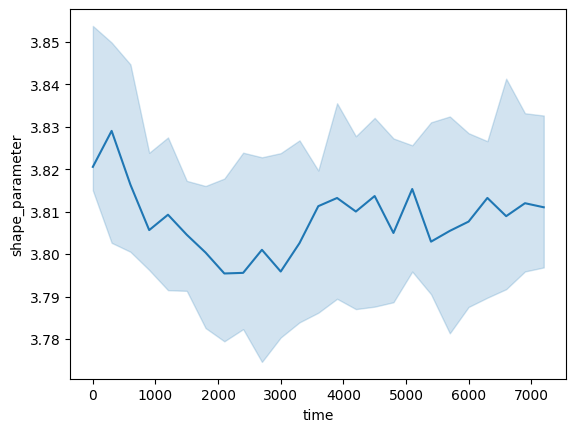

In [161]:
sns.lineplot(data=df, x='time', y='shape_parameter', estimator=np.median)